In [42]:
import duckdb
import json
import matplotlib.pyplot as plt
import os
import re
import numpy as np
import pandas as pd
import shapely
from datasets import load_dataset
from datetime import datetime
from dateutil import rrule
from shapely.geometry import LineString, Polygon, MultiPolygon, Point, MultiPoint
from shapely.geometry.base import BaseGeometry
from shapely.ops import polygonize, unary_union
from sklearn import svm
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from typing import Any, Dict
from joblib import Parallel, delayed
import math
import matplotlib.pyplot as plt

In [2]:
START_DATE = datetime(2025, 3, 1)
END_DATE = datetime(2025, 6, 30)

# Iterate through every month from START_DATE to END_DATE
all_months = list(rrule.rrule(rrule.MONTHLY, dtstart=START_DATE, until=END_DATE))

# Format as ISO dates
all_months = [x.strftime("%Y-%m-%d") for x in all_months]

In [3]:
# Load dataset from Hugging Face
ds = load_dataset("joefee/cell-service-data")

In [ ]:
# Convert to pandas dataframe
df = ds['train'].to_pandas()

In [5]:
# Browse the dataset
df

,timestamp,unique_cell,measurement_type_name,in_outdoor_state,value,latitude,longitude,signal_level
0,2025-03-01 15:48:22.455,d66c4660d6f77433b503d2e0159ce7053bdd76dc,None,None,-91.0,52.941137,-1.180972,-112.207920
1,2025-03-01 03:15:47.436,bb8abb3cfc1d2eb47edba5f216a0078d829575f2,None,Probably Indoor,-9.0,52.756933,-1.517308,-120.000000
2,2025-03-01 12:26:07.000,3fb387a3995398fc5602cc0e431ce935044c594e,None,Probably Outdoor,-108.0,52.770351,-1.208205,-108.719592
3,2025-03-01 09:49:03.000,e662f0bf857466dafbb8da554abfec2e86335deb,None,Surely Outdoor,46.8,52.644803,-1.189687,-103.070615
4,2025-03-01 00:56:44.711,0fed16bc81fbd0ef53e6071cf9fd8449d810fdfc,None,Surely Indoor,-7.0,52.887214,-1.534917,-96.205530
...,...,...,...,...,...,...,...,...
31504611,2025-06-30 09:21:01.666,5a6685a51c70f12cc7b03db00a18db684e60835c,None,Probably Indoor,1.4,52.641313,-1.095236,-86.808643
31504612,2025-06-30 06:38:45.485,71f3829f43969786e0adb953a0390146e67d1b3b,None,None,-109.0,52.771422,-1.197493,-102.676974
31504613,2025-06-30 15:24:45.000,334868f2087c2f62b8cf9d658ba7ffec4bf9ca77,None,Probably Outdoor,-105.0,52.645504,-1.126884,NaN
31504614,2025-06-30 01:56:10.540,0f96898a83142aa9cd14d8f27dfa1aa529af2fca,None,Probably Indoor,-14.0,52.627893,-1.336682,-104.649658


In [6]:
# Old dataset, unused
# df = pd.read_csv("hf://datasets/joefee/service-data/np_obs_jit_jf_tf_tw.csv")

In [7]:
# Bin this into signal level categories
# UK Ofcom Reference URL: 
# https://www.ofcom.org.uk/siteassets/resources/documents/phones-telecoms-and-internet/comparing-service-quality/2025/map-your-mobile-2025-threshold-methodology.pdf
df["signal_level_category"] = pd.cut(df["signal_level"], bins=[-np.inf, -105, -95, -82, -74, np.inf], labels=["1. Very Weak", "2. Weak", "3. Moderate", "4. Strong", "5. Very Strong"])

In [8]:
# Identify cells with sufficient data points
# Cells must also have signal_level_category value
min_points_required = 30

sufficient_data_cells = duckdb.query(f"""
WITH monthly_count AS (
    SELECT
        unique_cell, 
        date_trunc('month', CAST(timestamp AS timestamp)) as month, 
        COUNT(*) as count
    FROM df
    WHERE signal_level IS NOT NULL
    GROUP BY unique_cell, month HAVING COUNT(*) >= {30}
)
SELECT unique_cell 
FROM monthly_count 
GROUP BY unique_cell
HAVING COUNT(DISTINCT month) = {len(all_months)}
""").to_df()['unique_cell'].tolist()

In [9]:
# Identify all unique cells
# remove outlier cells
outlier_cells = ["4dc7c9ec434ed06502767136789763ec11d2c4b7"]
sufficient_data_cells = [cell for cell in sufficient_data_cells if cell not in outlier_cells]

print(f"Number of cells with sufficient data: {len(sufficient_data_cells)}")
print(f"Total number of cells: {df['unique_cell'].nunique()}")

Number of cells with sufficient data: 5244
Total number of cells: 36631


In [10]:
def generate_svm_boundary_geom(df, **args) -> BaseGeometry:
    """
    Generate a valid MultiPolygon with true cut-out holes from One-Class SVM boundary.
    Converts input longitude/latitude columns to float type if they are not already.

    Args:
        df (pd.DataFrame): DataFrame with 'longitude' and 'latitude' columns.
                        These columns can contain numbers or Decimal objects.
        **args: Keyword arguments passed directly to svm.OneClassSVM.

    Returns:
        BaseGeometry: A valid MultiPolygon geometry representing the SVM boundary,
                      or None if the boundary could not be created.
    """

    if not isinstance(df, pd.DataFrame) or not all(col in df.columns for col in ['longitude', 'latitude']):
        print("Error: Input df must be a pandas DataFrame with 'longitude' and 'latitude' columns.")
        return None

    if len(df) < 2:
        print("Warning: Need at least 2 data points for SVM.")
        return None

    # --- Convert coordinate columns to float type ---
    # This resolves the Decimal vs float TypeError
    try:
        df_copy = df.copy() # Work on a copy to avoid modifying the original DataFrame
        df_copy['longitude'] = df_copy['longitude'].astype(float)
        df_copy['latitude'] = df_copy['latitude'].astype(float)
        coords = df_copy[['longitude', 'latitude']].values
    except (TypeError, ValueError) as e:
        print(f"Error converting coordinate columns to float: {e}")
        return None

    # --- 1. Train the SVM ---
    try:
        clf = svm.OneClassSVM(**args)
        clf.fit(coords)
    except Exception as e:
        print(f"Error during SVM training: {e}")
        return None

    # --- 2. Create mesh grid for contouring ---
    # Now calculations will use standard floats
    x_min, x_max = coords[:, 0].min(), coords[:, 0].max()
    y_min, y_max = coords[:, 1].min(), coords[:, 1].max()

    x_range = x_max - x_min
    y_range = y_max - y_min
    x_margin = x_range * 1 if x_range > 1e-9 else 0.1
    y_margin = y_range * 1 if y_range > 1e-9 else 0.1

    x_min -= x_margin
    x_max += x_margin
    y_min -= y_margin
    y_max += y_margin

    resolution = 500
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, resolution),
                        np.linspace(y_min, y_max, resolution))
    grid_points = np.c_[xx.ravel(), yy.ravel()]

    try:
        Z = clf.decision_function(grid_points).reshape(xx.shape)
    except Exception as e:
        print(f"Error during SVM decision function evaluation: {e}")
        return None

    # --- 3. Extract contour lines at level 0 (the boundary) ---
    fig, ax = plt.subplots()
    try:
        cs = ax.contour(xx, yy, Z, levels=[0])
    except Exception as e:
        print(f"Error during contour generation: {e}")
        plt.close(fig)
        return None
    plt.close(fig)

    if not cs.allsegs or not cs.allsegs[0]:
        print("Warning: No contour lines found at level 0.")
        return None

    segments = cs.allsegs[0]
    lines = [LineString(seg) for seg in segments if len(seg) >= 2]

    if not lines:
        print("Warning: No valid LineStrings created from contour segments.")
        return None

    # --- 4. Polygonize the lines ---
    try:
        all_polygons = list(polygonize(lines))
    except Exception as e:
        print(f"Error during polygonization: {e}")
        return None

    if not all_polygons:
        print("Warning: Polygonization did not yield any polygons.")
        return None

    # --- 5. Classify polygons and perform unary union ---
    positive_polygons = []
    for p in all_polygons:
        if p.is_valid and p.area > 1e-9:
            rep_point = p.representative_point()
            try:
                decision_val = clf.decision_function([[rep_point.x, rep_point.y]])[0]
                if decision_val >= 0:
                    # Ensure the polygon added is valid - unary_union can struggle with invalid inputs
                    if p.is_valid:
                        positive_polygons.append(p)
                    else:
                    # Attempt to buffer by 0 to fix potential self-intersections
                        buffered_p = p.buffer(0)
                        if buffered_p.is_valid and isinstance(buffered_p, Polygon):
                                positive_polygons.append(buffered_p)
                        else:
                            print(f"Warning: Skipping invalid polygon generated during classification step even after buffer(0). Area: {p.area}")

            except Exception as e:
                print(f"Warning: Error checking decision function for a polygon point: {e}")


    if not positive_polygons:
        print("Warning: No valid polygons were classified as inside the SVM boundary.")
        return None

    # --- 6. Unary Union to merge positive polygons and create holes ---
    try:
        # Filter again for validity just before union, as buffer(0) might create MultiPolygons
        valid_positive_polygons = [poly for poly in positive_polygons if poly.is_valid and isinstance(poly, Polygon)]
        if not valid_positive_polygons:
            print("Warning: No valid polygons remaining before unary union.")
            return None
        result_geom = unary_union(valid_positive_polygons)

    except Exception as e:
        # Catch potential errors during unary_union (often related to complex topology)
        print(f"Error during unary union: {e}")
        # As a fallback, try creating a MultiPolygon directly from the valid positive polygons
        # This might result in overlaps instead of proper union, but is better than nothing.
        print("Attempting fallback: creating MultiPolygon from individual positive polygons.")
        try:
            result_geom = MultiPolygon(valid_positive_polygons)
            if not result_geom.is_valid:
                print("Warning: Fallback MultiPolygon is invalid.")
                # Try buffer(0) on the multipolygon as a last resort
                buffered_result = result_geom.buffer(0)
                if buffered_result.is_valid:
                    print("Fallback MultiPolygon fixed with buffer(0).")
                    result_geom = buffered_result
                else:
                    print("Error: Fallback MultiPolygon remains invalid even after buffer(0). Cannot proceed.")
                    return None
        except Exception as fallback_e:
            print(f"Error during fallback MultiPolygon creation: {fallback_e}")
            return None


    # --- 7. Format output as MultiPolygon GeoJSON mapping ---
    final_multi_poly = None
    if result_geom is None: # Should not happen with current logic, but check anyway
        print("Error: Resulting geometry is None after union/fallback.")
        return None

    # Simplify handling by ensuring result_geom is always iterable (list of polygons)
    geoms_to_wrap = []
    if isinstance(result_geom, Polygon):
        if result_geom.is_valid:
            geoms_to_wrap = [result_geom]
    elif isinstance(result_geom, MultiPolygon):
        # Filter out invalid geoms within the MultiPolygon if any
        geoms_to_wrap = [g for g in result_geom.geoms if g.is_valid and isinstance(g, Polygon)]
    elif hasattr(result_geom, 'geoms'): # Handle GeometryCollection
        print(f"Warning: unary_union resulted in a GeometryCollection. Filtering for valid Polygons.")
        geoms_to_wrap = [g for g in result_geom.geoms if g.is_valid and isinstance(g, Polygon)]

    if not geoms_to_wrap:
        print("Warning: No valid polygons found in the final geometry after union/cleanup.")
        return None

    # Create the final MultiPolygon
    final_multi_poly = MultiPolygon(geoms_to_wrap)

    # Final validity check
    if final_multi_poly.is_valid:
        return final_multi_poly
    else:
        # Try one last buffer(0) fix
        print("Warning: Final MultiPolygon is invalid. Attempting buffer(0) fix.")
        buffered_final = final_multi_poly.buffer(0)
        if buffered_final.is_valid and isinstance(buffered_final, (Polygon, MultiPolygon)):
            # Re-wrap if buffer resulted in a single Polygon
            if isinstance(buffered_final, Polygon):
                final_multi_poly = MultiPolygon([buffered_final])
            else:
                final_multi_poly = buffered_final
            print("Final MultiPolygon fixed with buffer(0).")
            return final_multi_poly
        else:
            print("Error: Final MultiPolygon remains invalid even after buffer(0).")
            return None

In [11]:
def generate_convex_hull_geom(df, quantile:float=0.95) -> BaseGeometry:
    """
    Generate a valid convex hull MultiPolygon from input DataFrame.
    Converts input longitude/latitude columns to float type if they are not already.

    Args:
        df (pd.DataFrame): DataFrame with 'longitude' and 'latitude' columns.
        **args: Currently unused, present for API consistency.
    Returns:
        BaseGeometry: Shapely geometry object representing the convex hull, or None if unsuccessful.
    """

    # Construct a convex hull with shapely using train_df
    points_train = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]

    # Find center of mass among these points
    multipoint = MultiPoint(points_train)
    center_of_mass = multipoint.centroid

    # For each point, calculate distance to center of mass
    distances = [point.distance(center_of_mass) for point in points_train]
    
    # Find the 95% percentile distance
    threshold_distance = pd.Series(distances).quantile(quantile)

    # Filter points to only those within the threshold distance
    filtered_points = [point for point, distance in zip(points_train, distances) if distance <= threshold_distance]

    # Create new multipoint from filtered points
    multipoint_filtered = MultiPoint(filtered_points)
    
    # Calculate the convex hull
    convex_hull = multipoint_filtered.convex_hull

    if convex_hull.is_valid:
        return convex_hull
    else:
        print("Warning: Convex hull is invalid.")
        return None

In [12]:
def get_classification_metric(y_true, y_pred, metric:str):
    """
    Compute a specific classification metric based on the provided metric name.
    Handles zero division by returning 0 for precision, recall, and F1 score in such cases.

    Args:
        y_true (list): True binary labels.
        y_pred (list): Predicted binary labels.
        metric (str): Metric to compute - one of 'accuracy', 'precision', 'recall', 'f1'.
    
    Returns:
        float: The computed metric score.
    """
    metric = metric.lower()
    if metric == 'accuracy':
        return accuracy_score(y_true, y_pred)
    elif metric == 'precision':
        return precision_score(y_true, y_pred, zero_division=0)
    elif metric == 'recall':
        return recall_score(y_true, y_pred, zero_division=0)
    elif metric == 'f1':
        return f1_score(y_true, y_pred, zero_division=0)
    else:
        raise ValueError(f"Unsupported metric: {metric}. Choose from 'accuracy', 'precision', 'recall', 'f1'.")

In [53]:
# Identify cells already processed in folder
processed_cells = [re.search(r"cell_([a-zA-Z0-9]*)_metrics.csv", f).group(1) for f in os.listdir("cells") if re.match(r"cell_[a-zA-Z0-9]*_metrics.csv", f)]

# Remove those already processed
sufficient_data_cells = [cell for cell in sufficient_data_cells if cell not in processed_cells]

In [56]:
# allowed_cells = ["5a6685a51c70f12cc7b03db00a18db684e60835c"]

# Take the top X cells for processing
allowed_cells = sufficient_data_cells[0:300]

In [58]:
def process_cell(cell_id:str, metric:str='f1'):
    """
    Process a single cell to generate coverage boundaries using Convex Hull and SVM methods.
    Evaluates the boundaries using a specified classification metric and saves results to GeoJSON and CSV files

    Args:
        cell_id (str): The unique identifier of the cell to process.
        metric (str): The classification metric to use for evaluation (default: 'f1').
    """
    import os
    
    my_geojson = {
        "type": "FeatureCollection",
        "features": []
    }

    my_best_convex_hull:Dict[Any, tuple[float, BaseGeometry]] = {}
    my_best_svm_hyperplanes:Dict[Any, tuple[float, BaseGeometry]] = {}

    # Select data for this cell only
    df_cell = df[df['unique_cell'] == cell_id]
    print(f"---")
    print(f"Processing cell {cell_id}")

    # Exclude last month
    for month in all_months[:-1]:
        
        # Identify train/test split
        # Use one month for training, next month for testing
        df_train = df_cell[(pd.to_datetime(df_cell['timestamp']).dt.to_period('M') == pd.to_datetime(month).to_period('M'))]
        test_month = (pd.to_datetime(month).to_period('M') + 1).strftime("%Y-%m-%d")
        
        # For df_test, use all points regardless of cells.
        # Subset +- longitude/latitude range of training data by 20%
        # Crop to a bounding box to avoid huge area
        lon_min, lon_max = df_train['longitude'].min(), df_train['longitude'].max()
        lat_min, lat_max = df_train['latitude'].min(), df_train['latitude'].max()

        lon_margin = (lon_max - lon_min) * 0.2 if (lon_max - lon_min) > 1e-9 else 0.01
        lat_margin = (lat_max - lat_min) * 0.2 if (lat_max - lat_min) > 1e-9 else 0.01
        lon_min -= lon_margin
        lon_max += lon_margin
        lat_min -= lat_margin
        lat_max += lat_margin

        # Subset the test month and all data within the expanded bounding box
        df_test = df[(pd.to_datetime(df['timestamp']).dt.to_period('M') == pd.to_datetime(test_month).to_period('M')) &
                      (df['longitude'] >= lon_min) & (df['longitude'] <= lon_max) &
                      (df['latitude'] >= lat_min) & (df['latitude'] <= lat_max)]
        
        # Sample down test set if too large
        # Cap data points at 50% for testing to speed up evaluation
        n_test = int(len(df_test) * 0.5)
        if len(df_test) > n_test:
            df_test = df_test.sample(n=n_test).reset_index(drop=True)

        print(f"---Training month: {month}, Testing month: {test_month}---")
        print(f"Train: {len(df_train)}, Test: {len(df_test)}")

        # OC-SVM arguments
        svm_args = {
            'kernel': 'rbf',
            'nu': float(0.08),  # Lower value allow more flexible boundary
            'gamma': float(len(df_train) * 30)  # Higher value allow more complex decision boundary
        }

        # Convex hull arguments
        convex_hull_args = {
            'quantile': 0.98
        }

        # Run boundary generation for different signal level categories
        # Starting from very weak to very strong
        # Cumulative union of all these geoms to ensure coverage of all signal levels
        levels = {
            5: ["5. Very Strong"],
            4: ["4. Strong", "5. Very Strong"],
            3: ["3. Moderate", "4. Strong", "5. Very Strong"],
            2: ["2. Weak", "3. Moderate", "4. Strong", "5. Very Strong"],
            1: ["1. Very Weak", "2. Weak", "3. Moderate", "4. Strong", "5. Very Strong"],
        }
        
        # Generate SVM boundaries for each level
        for key, level in levels.items():
            df_subset_level_train = df_train[df_train["signal_level_category"].isin(level)]
            print(f"Generating SVM for cell {cell_id} at levels {level} with {len(df_subset_level_train)} training points")

            # Use all levels for testing
            df_subset_level_test = df_test

            if len(df_subset_level_train) < min_points_required:
                print(f"Skipping SVM for cell {cell_id} at levels {level} due to insufficient points ({len(df_subset_level_train)} < {min_points_required})")
                continue
            
            # Convert to shapely Points
            points_level_train = [Point(xy) for xy in zip(df_subset_level_train['longitude'], df_subset_level_train['latitude'])]
            points_level_test = [Point(xy) for xy in zip(df_subset_level_test['longitude'], df_subset_level_test['latitude'])]
            
            # Generate convex hull for this level
            convex_hull = generate_convex_hull_geom(df_subset_level_train, **convex_hull_args)

            # Run SVM boundary generation
            buffer = 0.000 
            # svm_hyperplane = generate_svm_boundary_geom(df_subset_level_train, **svm_args)

            # Perform grid search over SVM hyperparameters to find best model
            svm_args = [
                {"kernel": "rbf", "nu": float(0.02), "gamma": float(3.0e4)},
                {"kernel": "rbf", "nu": float(0.02), "gamma": float(2.0e4)},
                {"kernel": "rbf", "nu": float(0.02), "gamma": float(1.0e4)},

                {"kernel": "rbf", "nu": float(0.04), "gamma": float(3.0e4)},
                {"kernel": "rbf", "nu": float(0.04), "gamma": float(2.0e4)},
                {"kernel": "rbf", "nu": float(0.04), "gamma": float(1.0e4)},

                {"kernel": "rbf", "nu": float(0.06), "gamma": float(3.0e4)},
                {"kernel": "rbf", "nu": float(0.06), "gamma": float(2.0e4)},
                {"kernel": "rbf", "nu": float(0.06), "gamma": float(1.0e4)},
            ]
            
            def replace_if_better(
                metric_model:tuple[float, BaseGeometry], 
                current_metric_value:float, 
                geometry:BaseGeometry, 
                metric:str,
                model_name:str,
            ) -> tuple[float, BaseGeometry]:
                """
                Replace the metric model if the current metric value is better.
                """

                if metric_model is None:
                    print(f"Best {model_name} model found for metric '{metric}': {current_metric_value}")
                    return (current_metric_value, geometry)
                else:
                    if current_metric_value > metric_model[0]:
                        print(f"Better {model_name} model found for metric '{metric}': {metric_model[0]} -> {current_metric_value}")
                        return (current_metric_value, geometry)
                    
                    return metric_model
            
            # Calculate true labels for test set
            # It is true if the point is in any of the levels being considered and belonging to the same unique_cell
            # Note: y_true is the same for both models since test set is the same
            y_true = [row.signal_level_category in level and row.unique_cell==cell_id for row in df_subset_level_test.itertuples()]
            # y_true = [x in level for x in df_subset_level_test["signal_level_category"].tolist()]

            # Grid search over SVM hyperparameters
            svm_hyperplane = None
            best_svm_metric = -1.0

            for args in svm_args:

                # Using SVM args
                print(f"Trying SVM args: {args}")
                svm_hyperplane = generate_svm_boundary_geom(df_subset_level_train, **args)

                if svm_hyperplane is not None:
                    # Add buffer radius to have wider coverage
                    if buffer > 0:
                        try:
                            print(f"Applying buffer of {buffer} degrees to SVM geometry")
                            svm_hyperplane = svm_hyperplane.buffer(buffer)
                        except Exception as e:
                            print(f"Warning: buffering geometry failed for cell {cell_id}, levels {level}: {e}")

                    # Construct confusion matrix values
                    y_pred_svm = [True if svm_hyperplane.contains(point) else False for point in points_level_test]

                    # Calculate metrics for SVM method
                    metric_svm = get_classification_metric(y_true, y_pred_svm, metric)

                    # Store the best SVM model
                    my_best_svm_hyperplanes[key] = replace_if_better(my_best_svm_hyperplanes.get(key, None), metric_svm, svm_hyperplane, metric, "svm")

            # Calculate y_pred for convex hull
            y_pred_chull = [True if convex_hull.contains(point) else False for point in points_level_test]

            # Calculate metrics for convex hull method
            my_metric_chull = get_classification_metric(y_true, y_pred_chull, metric)

            # Store the best convex hull model
            my_best_convex_hull[key] = replace_if_better(my_best_convex_hull.get(key, None), my_metric_chull, convex_hull, metric, "convex hull")


    def ensure_overlapping_polygons(data:Dict[Any,tuple[float, BaseGeometry]]) -> Dict[Any,tuple[float, BaseGeometry]]:
        """
        Ensure that successive geometries in the input dictionary are fully overlapping.
        For example, level 5 should be fully within level 4, and level 4 within level 3, etc.
        This means level 4 is the union of level 4 and level 5, level 3 is the union of level 3, level 4 and level 5, etc.

        Args:
            data (Dict[Any, tuple[float, BaseGeometry]]): Dictionary with keys and (metric, geometry) tuples.
        Returns:
            Dict[Any, tuple[float, BaseGeometry]]: Filtered dictionary with only overlapping polygons.
        """
        
        sorted_keys = sorted(data.keys(), reverse=True)  # Start from highest level
        accumulated_geom = None
        filtered_data = {}

        for key in sorted_keys:
            metric, geom = data[key]
            if geom is None or not geom.is_valid:
                print(f"Warning: Skipping invalid or None geometry for level {key}.")
                continue

            if accumulated_geom is None:
                accumulated_geom = geom
            else:
                try:
                    accumulated_geom = accumulated_geom.union(geom)
                except Exception as e:
                    print(f"Warning: Union operation failed for level {key}: {e}")
                    continue

            filtered_data[key] = (metric, accumulated_geom)

        # Reverse back to original order
        return dict(sorted(filtered_data.items()))

    # Ensure overlapping polygons for both models
    my_best_convex_hull = ensure_overlapping_polygons(my_best_convex_hull)
    my_best_svm_hyperplanes = ensure_overlapping_polygons(my_best_svm_hyperplanes)

    # Compare the metrics of these two methods
    metrics_chull = [(k, my_best_convex_hull[k][0]) for k in my_best_convex_hull.keys()]
    metrics_svm = [(k, my_best_svm_hyperplanes[k][0]) for k in my_best_svm_hyperplanes.keys()]

    metrics_df = pd.DataFrame(metrics_chull, columns=['level', 'chull']).merge(
        pd.DataFrame(metrics_svm, columns=['level', 'svm']), on='level', how='outer'
    )

    # Add unique_cell column
    metrics_df["unique_cell"] = cell_id

    # Export this cell's metrics to CSV
    os.makedirs('cells', exist_ok=True)
    metrics_df.to_csv(f"cells/cell_{cell_id}_metrics.csv", index=False)


    # Append the best convex hulls to list
    for key, value in my_best_convex_hull.items():
        my_geojson['features'].append({
            "type": "Feature",
            "properties": {
                "cell_id": cell_id,
                "levels": key,
                "model": "convex_hull",
                "fill": "#1100FF",
            },
            "geometry": shapely.geometry.mapping(value[1]),
        })

    # Append the best SVM hyperplanes to list
    for key, value in my_best_svm_hyperplanes.items():
        my_geojson['features'].append({
            "type": "Feature",
            "properties": {
                "cell_id": cell_id,
                "levels": key,
                "model": "svm",
                "fill": "#FF0000",
            },
            "geometry": shapely.geometry.mapping(value[1]),
        })
        
    # Export geojson for this cell
    import os
    os.makedirs('cells', exist_ok=True)
    with open(f"cells/cell_{cell_id}.geojson", "w") as f:
        json.dump(my_geojson, f, indent=2)

In [ ]:
metric = "f1"
Parallel(n_jobs=100)(delayed(process_cell)(x, metric) for x in sufficient_data_cells if x in allowed_cells)

c:\Users\Timothy Wong\Repositories\mobile_coverage\.venv\Lib\site-packages\joblib\externals\loky\process_executor.py:1105: UserWarning: On Windows, max_workers cannot exceed 61 due to limitations of the operating system.
  warnings.warn(
c:\Users\Timothy Wong\Repositories\mobile_coverage\.venv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [43]:
# List all files directory with matching regex pattern
metrics_files = [f for f in os.listdir("cells") if re.match(r"cell_[a-zA-Z0-9]*_metrics.csv", f)]

# Load all csvs and concatenate into a single dataframe
metrics_all = pd.concat([pd.read_csv(f"cells/{f}") for f in metrics_files], ignore_index=True)

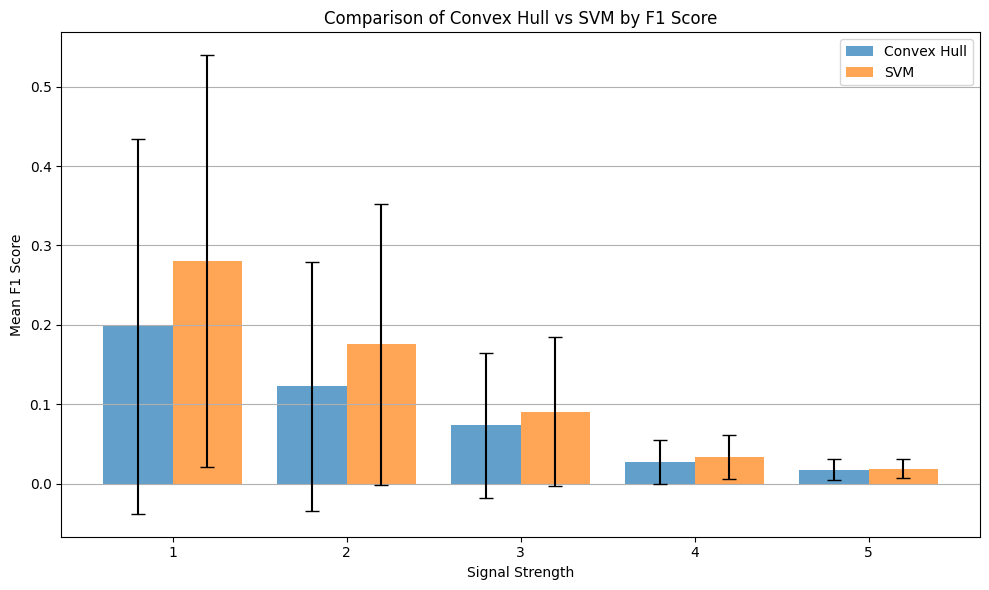

In [44]:
# Plot metrics for convex hull vs SVM at different levels
# Use bar plot with error bars to compare the metrics side by side

# Calculate the error bars (standard deviation) for each method at each level
metrics_summary = metrics_all.groupby('level').agg({
    'chull': ['mean', 'std'],
    'svm': ['mean', 'std']
}).reset_index()

metrics_summary.columns = ['level', 'chull_mean', 'chull_std', 'svm_mean', 'svm_std']

# Plotting (bars side by side with error bars)
# Use log scale
plt.figure(figsize=(10, 6))
plt.bar(metrics_summary['level'].astype(str).astype(float) - 0.2, metrics_summary['chull_mean'], yerr=metrics_summary['chull_std'], width=0.4, label='Convex Hull', alpha=0.7, capsize=5)
plt.bar(metrics_summary['level'].astype(str).astype(float) + 0.2, metrics_summary['svm_mean'], yerr=metrics_summary['svm_std'], width=0.4, label='SVM', alpha=0.7, capsize=5)
plt.xlabel('Signal Strength')
plt.ylabel(f'Mean {metric.upper()} Score')
plt.title(f'Comparison of Convex Hull vs SVM by {metric.upper()} Score')
plt.xticks(metrics_summary['level'].astype(str).astype(float), metrics_summary['level'].astype(str))
plt.legend()
plt.grid(axis='y')
plt.tight_layout()